In [1]:
import gurobipy as gb
import networkx as nx
import matplotlib.pyplot as plt
import os


#
# Drawing 
# functions
#


def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
        

    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        


        
        
    
    plt.axis('off')
    plt.show()


def DrawSubtour (G, x, subtour):

    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}


    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o',
                           nodelist=subtour,
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    

    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]
    
    for u,v in subtouredges:
        if x[u,v].x > 0.01 and x[u,v].x < 0.99:

            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],
                                   edge_color='r')

            nx.draw_networkx_edge_labels(G, pos=pos, 
                                         edge_labels={(u,v):f'[{x[u,v].x:.2f}, {x[v,u].x:.2f}]'})

            
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],\
                                   edge_color='k')
            
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    scale = 15
    figsize = (10,10)

## mTSP

>**Given**
>A directed graph $G=(N,A)\;$ and a cost $c_{ij} > 0$ for each arc in $A$
>
>**Find**
> A set of routes for $m$ salesmen who all start from and turn back to a home city (depot, node 1) 
 


### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} c_{ij} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j = 2}^{j=n} x_{1j} &= m  \;\; \text{(OUT-R)}\\
\sum_{i = 2}^{i=n} x_{i1} &= m \;\; \text{(IN-R)}\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(RS)}\\
\sum_{(i,j) \in A(S)} x_{ij} &\le |S| - 1 \;\; \forall S \subset N \setminus \{1\}, |S| \ge 2 \;\; \text{(SEC)}\\
\text {or}\\
\sum_{(i,j) \in \delta^+(S)} x_{ij} &\ge 1 \;\; \forall S \subset N, \{1\} \in S\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

In [2]:
# 
# Read the graph in the graphML format
#


args.filename = 'atsp28.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())

args.figsize = (20,20)

#print(G.edges(data=True))

G has 28 nodes and 756 edges
True


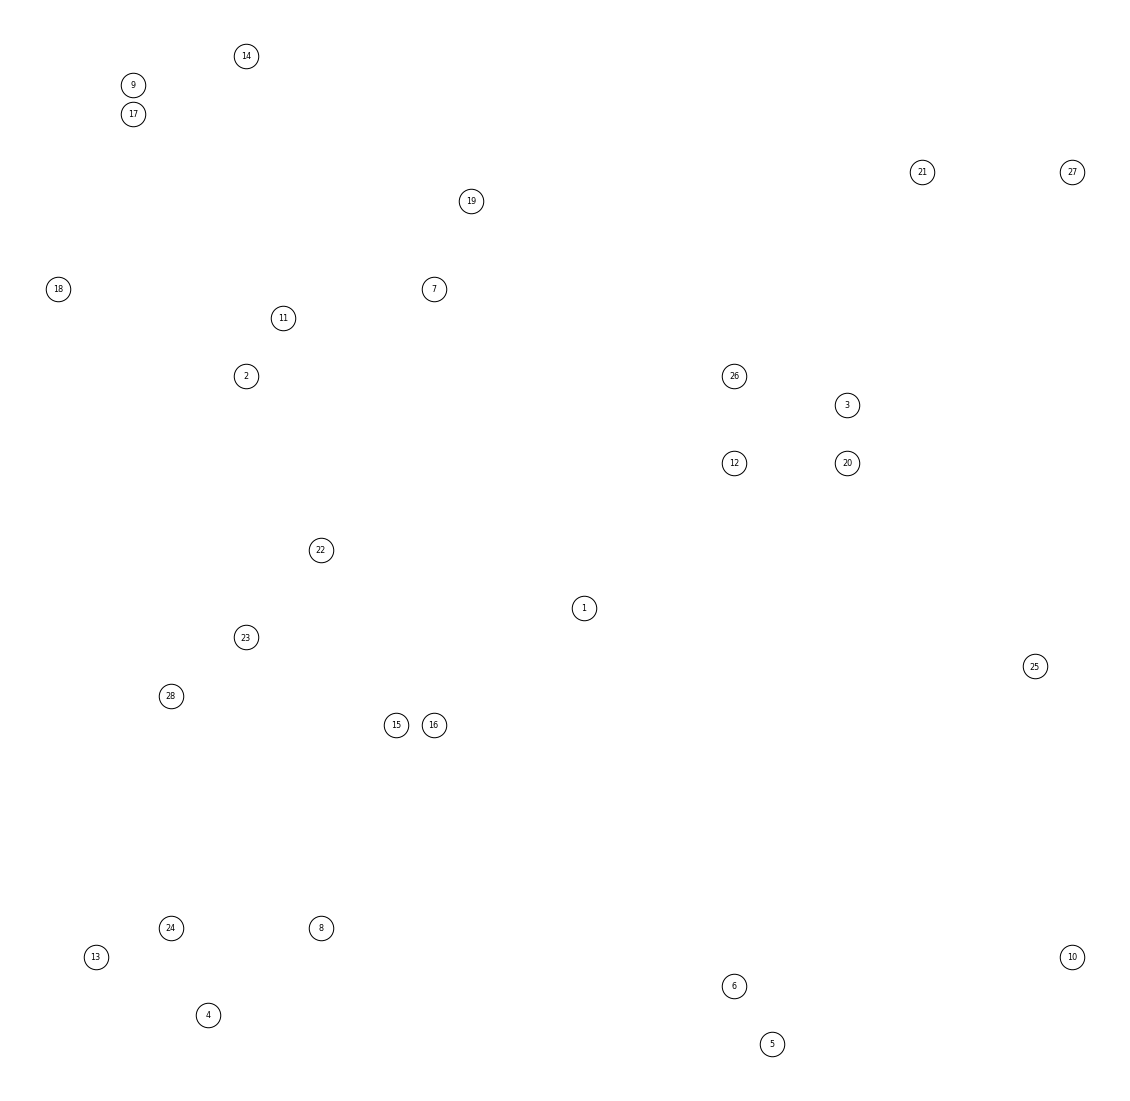

In [3]:
root = list(G.nodes())[0]

DrawInitG(G)



## mTSP: Branch-and-cut

In [4]:
m = 4

In [5]:
mtsp = gb.Model()

x = mtsp.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')


Academic license - for non-commercial use only - expires 2021-07-16
Using license file /Users/fabrizio/Solvers/licenses/gurobi.lic


In [6]:
mtsp.addConstr(x.sum(root,'*') == m, name = 'OUT-R')
mtsp.addConstr(x.sum('*',root) == m, name = 'IN-R')

<gurobi.Constr *Awaiting Model Update*>

In [7]:
mtsp.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes() if i != root), name='FS')

mtsp.update()

In [8]:
mtsp.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes() if i != root), name='RS')

mtsp.update()

In [9]:
mtsp.addConstrs((x[i,j] + x[j,i] <= 1 \
                 for i,j in G.edges() \
                 if j > i and i != root and j != root ),\
                name='SUB2')

mtsp.update()

In [10]:
mtsp.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 407 rows, 756 columns and 2214 nonzeros
Model fingerprint: 0x64f57339
Variable types: 0 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 54266.000000
Presolve time: 0.01s
Presolved: 407 rows, 756 columns, 2214 nonzeros
Variable types: 0 continuous, 756 integer (756 binary)

Root relaxation: objective 1.728500e+04, 73 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    17285.000000 17285.0000  0.00%     -    0s

Explored 0 nodes (73 simplex iterations) in 0.02 seconds
Thread count was 8 (of 8 available

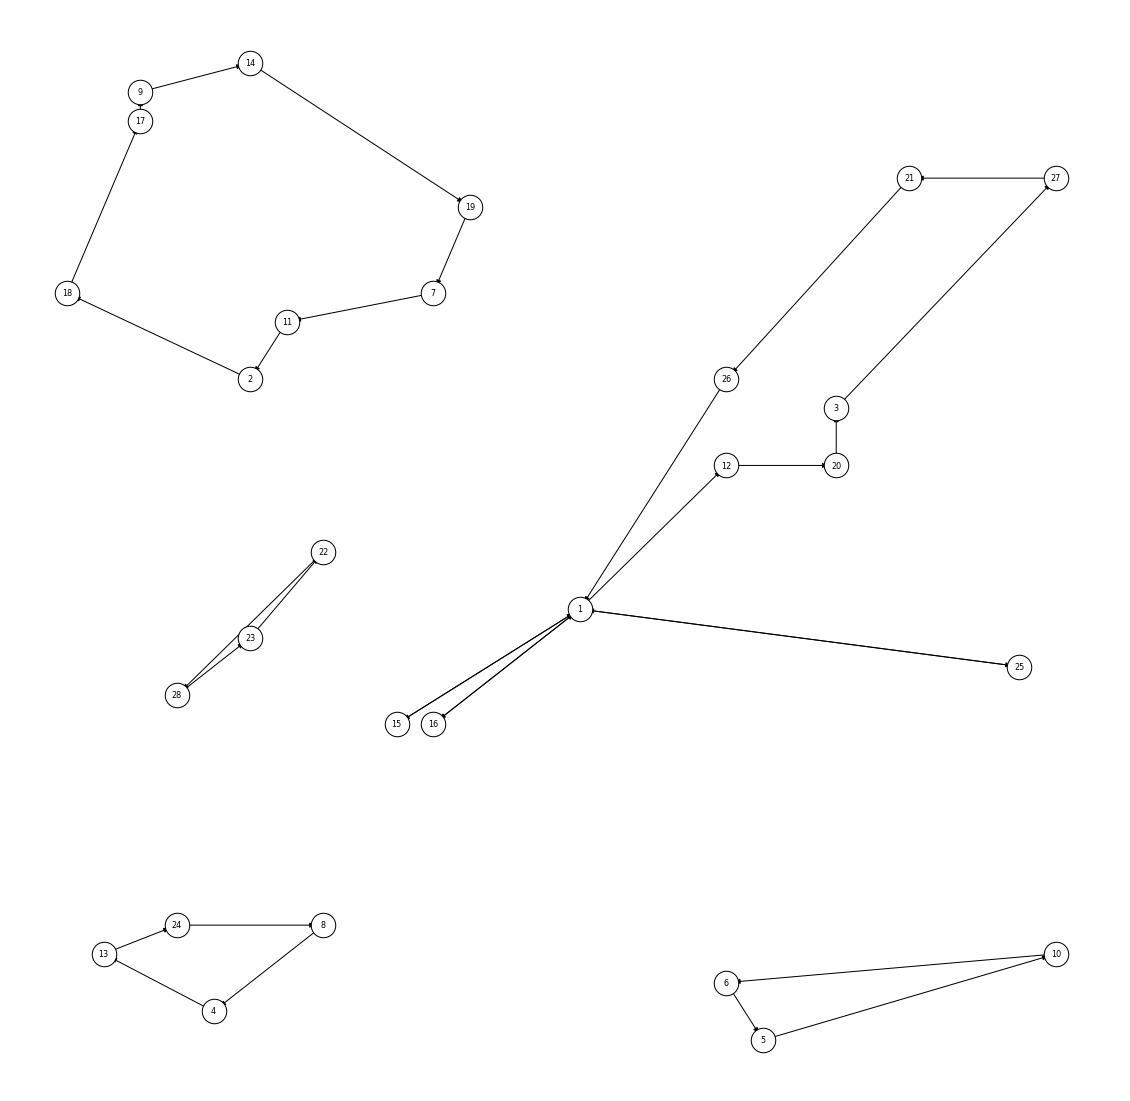

In [11]:
DrawSol(G,x)


In [12]:

mtsp._graph = G
mtsp._vars = x



## SEC separation callback (Lazy Constraints)

In [13]:
def SEC_lazy_callback (model, where):

    #
    # SEC Constraints of form 2 above
    #
        
    if where == gb.GRB.Callback.MIPSOL:
        
        x = model._vars
        xrel = model.cbGetSolution(x)
        G = model._graph
                        
        for i,j in G.edges():
            G[i][j]['capacity'] = xrel[i,j]
        
        for i in list(G.nodes())[2:]:
                cut_val, cut = nx.minimum_cut(G,1,i)

                if cut_val < 0.99999:

                    cutarcs = [(u,v) for u in cut[0] for v in cut[1] if G.has_edge(u,v)]

                    model.cbLazy(gb.quicksum(x[i,j] for i,j in cutarcs) >= 1)
                    break
                

In [15]:
mtsp.reset()
mtsp.Params.lazyConstraints = 1
mtsp.optimize(SEC_lazy_callback)

Discarded solution information
Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 407 rows, 756 columns and 2214 nonzeros
Model fingerprint: 0x64f57339
Variable types: 0 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 54266.000000
Presolve time: 0.01s
Presolved: 407 rows, 756 columns, 2214 nonzeros
Variable types: 0 continuous, 756 integer (756 binary)

Root relaxation: objective 1.728500e+04, 73 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 18465.5000    0   22 54266.0000 1846

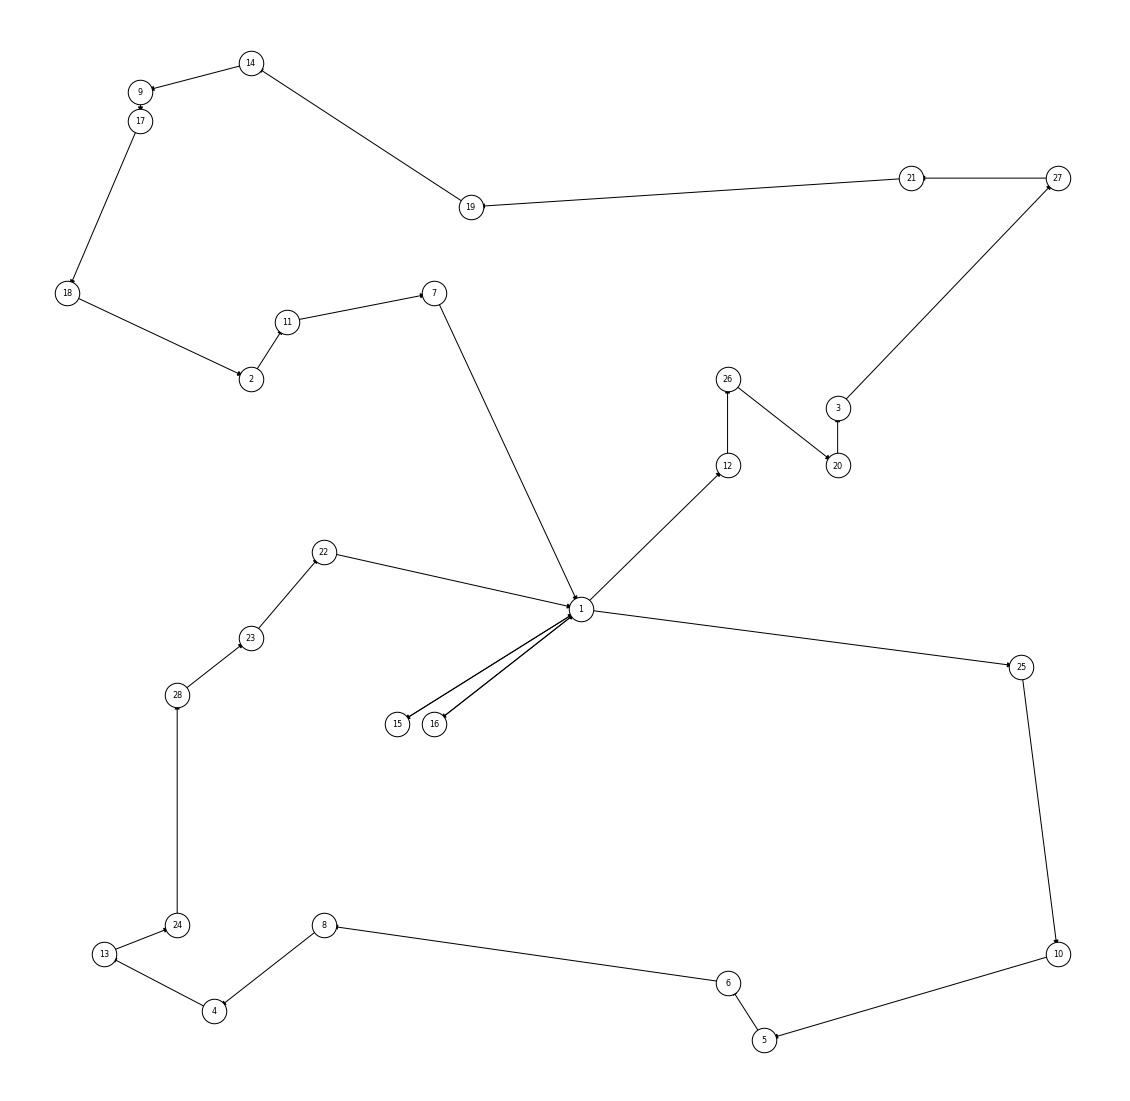

In [16]:
DrawSol(G,x)

## mTSP MTZ constraints

### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j = 2}^{j=n} x_{1j} &= m  \;\; \text{(OUT-R)}\\
\sum_{i = 2}^{i=n} x_{i1} &= m \;\; \text{(IN-R)}\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(RS)}\\
u_i - u_j + p x_{ij} &\le p-1 \;\; \forall (i,j) \in A, i,j \not = 1\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

In [17]:
m = 4
p = 10

In [18]:
mtsp_mtz = gb.Model()

x = mtsp_mtz.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')


mtsp_mtz.write('mtsp_mtz.lp')

In [19]:
mtsp_mtz.addConstr(x.sum(root,'*') == m, name = 'OUT-R')
mtsp_mtz.addConstr(x.sum('*',root) == m, name = 'IN-R')
mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [20]:
mtsp_mtz.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes() if i != root), name='FS')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [21]:
mtsp_mtz.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes() if i != root), name='RS')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [22]:
mtsp_mtz.addConstrs((x[i,j] + x[j,i] <= 1 \
                 for i,j in G.edges() if j > i \
                     and i != root and j != root ), name='SUB2')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [23]:
u[root].lb = 0
u[root].ub = 0

mtsp_mtz.addConstrs((u[i] - u[j] + p * x[i,j] <= p - 1 \
                     for i in G.nodes() for j in G.nodes()\
                    if i != j and i != root and j != root and G.has_edge(i,j)), name='MTZ')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')


mtsp_mtz._graph = G
mtsp_mtz._vars = x


In [24]:
mtsp_mtz.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1109 rows, 784 columns and 4320 nonzeros
Model fingerprint: 0xb075d8d7
Variable types: 28 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 1109 rows, 783 columns, 4320 nonzeros
Variable types: 27 continuous, 756 integer (756 binary)

Root relaxation: objective 1.729400e+04, 126 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 17294.0000    0   36          - 17294.0000      -     -    0s
H    0     0                    47389.000000 17294.0000  63.5%     -    0s
H    0     0           

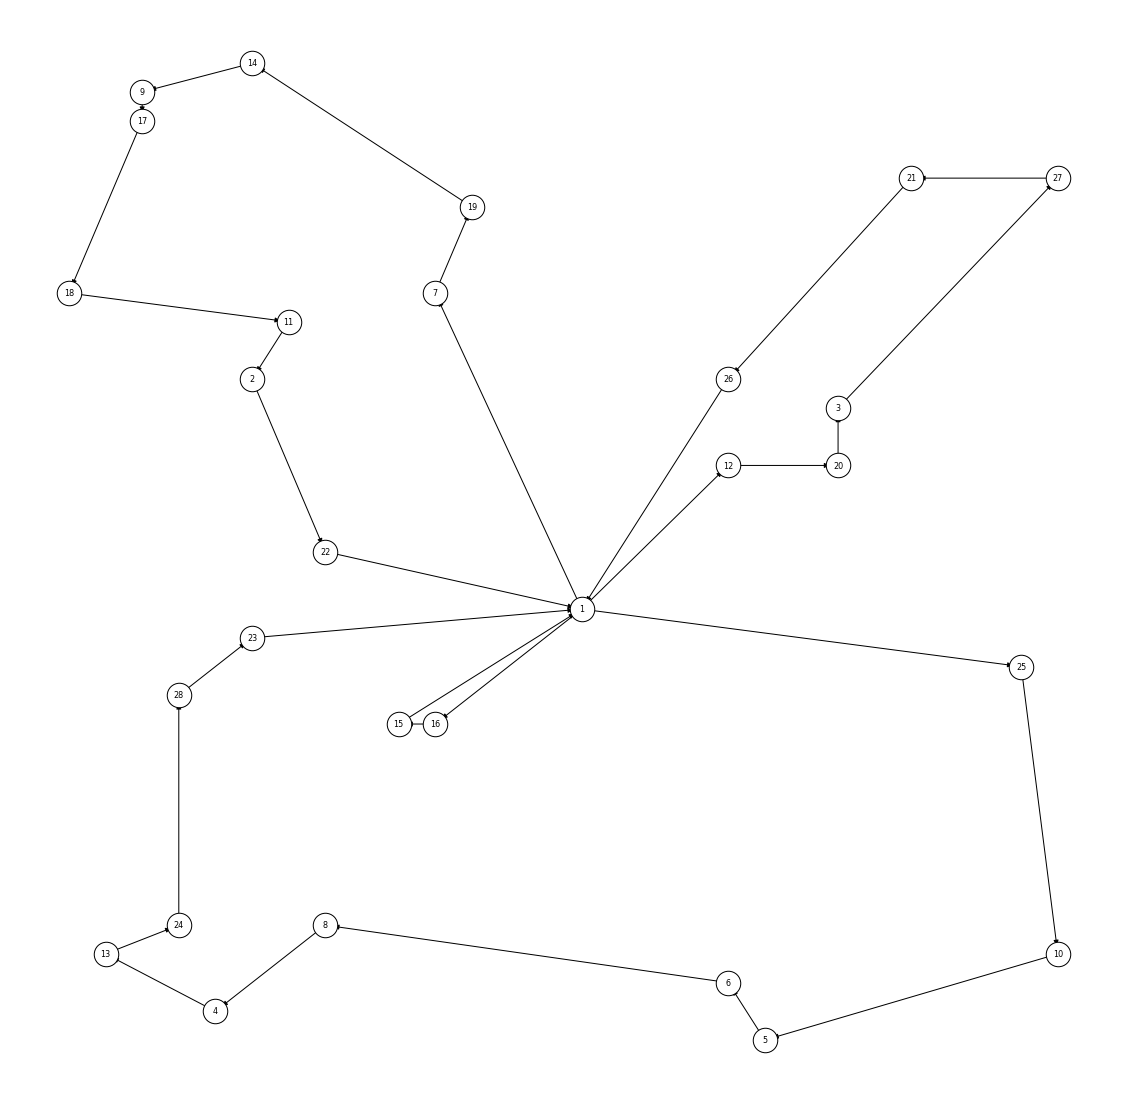

In [25]:
DrawSol(G, x)

In [26]:
u

{1: <gurobi.Var u[1] (value 0.0)>,
 2: <gurobi.Var u[2] (value 8.0)>,
 3: <gurobi.Var u[3] (value 7.000000000000032)>,
 4: <gurobi.Var u[4] (value 5.999999999999976)>,
 5: <gurobi.Var u[5] (value 2.9999999999999956)>,
 6: <gurobi.Var u[6] (value 3.9999999999999876)>,
 7: <gurobi.Var u[7] (value 1.0)>,
 8: <gurobi.Var u[8] (value 4.999999999999976)>,
 9: <gurobi.Var u[9] (value 4.0)>,
 10: <gurobi.Var u[10] (value 1.9999999999999953)>,
 11: <gurobi.Var u[11] (value 7.0)>,
 12: <gurobi.Var u[12] (value 5.0000000000000595)>,
 13: <gurobi.Var u[13] (value 6.999999999999978)>,
 14: <gurobi.Var u[14] (value 3.0)>,
 15: <gurobi.Var u[15] (value 10.0)>,
 16: <gurobi.Var u[16] (value 9.0)>,
 17: <gurobi.Var u[17] (value 5.0)>,
 18: <gurobi.Var u[18] (value 6.0)>,
 19: <gurobi.Var u[19] (value 2.0)>,
 20: <gurobi.Var u[20] (value 6.000000000000049)>,
 21: <gurobi.Var u[21] (value 9.0)>,
 22: <gurobi.Var u[22] (value 9.0)>,
 23: <gurobi.Var u[23] (value 9.999999999999982)>,
 24: <gurobi.Var u[24]

## Formulation strengthening through the Cut Callback

In [27]:
def SEC_cut_callback (model, where):

    #
    # SEC Constraints of form 2 above
    #


        
    if where == gb.GRB.Callback.MIPNODE:
        status = model.cbGet(gb.GRB.Callback.MIPNODE_STATUS)
        count = model.cbGet(gb.GRB.Callback.MIPNODE_NODCNT)
        if status == gb.GRB.OPTIMAL and count < 10:
            x = model._vars
            xrel = model.cbGetNodeRel(x) 
            G = model._graph
                        
            for i,j in G.edges():
                G[i][j]['capacity'] = xrel[i,j]

            for i in list(G.nodes())[1:]:
                cut_val, cut = nx.minimum_cut(G,1,i)

                if cut_val < 0.99999:

                    cutarcs = [(u,v) for u in cut[0] for v in cut[1] if G.has_edge(u,v)]

                    model.cbCut(gb.quicksum(x[i,j] for i,j in cutarcs) >= 1)
                    break
                    


In [28]:
mtsp_mtz.reset()
mtsp_mtz.Params.PreCrush = 1
mtsp_mtz.Params.lazyConstraints = 0



mtsp_mtz.optimize(SEC_cut_callback)


Discarded solution information
Changed value of parameter PreCrush to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Parameter lazyConstraints unchanged
   Value: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1109 rows, 784 columns and 4320 nonzeros
Model fingerprint: 0xb075d8d7
Variable types: 28 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 1109 rows, 783 columns, 4320 nonzeros
Variable types: 27 continuous, 756 integer (756 binary)

Root relaxation: objective 1.729400e+04, 126 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | 

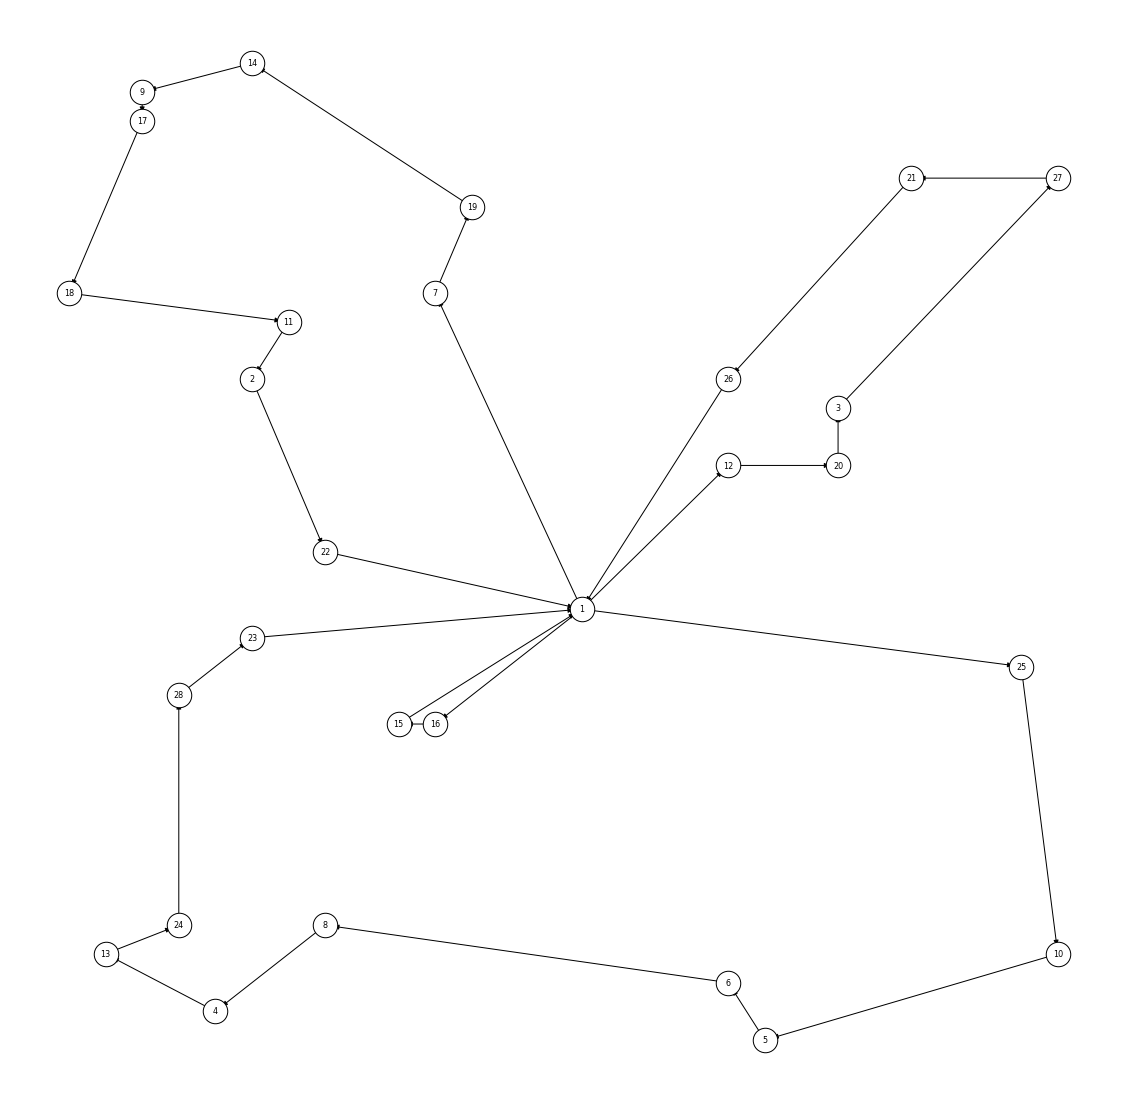

In [29]:
DrawSol(G,x)


In [30]:
u

{1: <gurobi.Var u[1] (value 0.0)>,
 2: <gurobi.Var u[2] (value 7.999999999999945)>,
 3: <gurobi.Var u[3] (value 2.999999999999983)>,
 4: <gurobi.Var u[4] (value 6.0)>,
 5: <gurobi.Var u[5] (value 3.0)>,
 6: <gurobi.Var u[6] (value 3.9999999999999942)>,
 7: <gurobi.Var u[7] (value 1.0)>,
 8: <gurobi.Var u[8] (value 5.0)>,
 9: <gurobi.Var u[9] (value 3.9999999999999853)>,
 10: <gurobi.Var u[10] (value 2.0)>,
 11: <gurobi.Var u[11] (value 6.999999999999961)>,
 12: <gurobi.Var u[12] (value 1.0)>,
 13: <gurobi.Var u[13] (value 6.999999999999983)>,
 14: <gurobi.Var u[14] (value 2.9999999999999902)>,
 15: <gurobi.Var u[15] (value 10.0)>,
 16: <gurobi.Var u[16] (value 9.0)>,
 17: <gurobi.Var u[17] (value 4.9999999999999805)>,
 18: <gurobi.Var u[18] (value 5.999999999999973)>,
 19: <gurobi.Var u[19] (value 2.0)>,
 20: <gurobi.Var u[20] (value 2.0)>,
 21: <gurobi.Var u[21] (value 4.999999999999954)>,
 22: <gurobi.Var u[22] (value 10.0)>,
 23: <gurobi.Var u[23] (value 10.0)>,
 24: <gurobi.Var u[2